This sample file is an example of a background/signal classification. The background is Standard Model and the signal is Zprime in this example. 

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

Loading all the background and signal samples

In [3]:
train_bkg0 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/training_bkg_2L_pt25_25_met50_0.h5")
train_bkg1 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/training_bkg_2L_pt25_25_met50_1.h5")
train_bkg2 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/training_bkg_2L_pt25_25_met50_2.h5")
train_bkg3 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/training_bkg_2L_pt25_25_met50_3.h5")
train_bkg5 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/training_bkg_2L_pt25_25_met50_5.h5")
train_bkg7 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/training_bkg_2L_pt25_25_met50_7.h5")
train_bkg8 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/training_bkg_2L_pt25_25_met50_8.h5")
train_bkg9 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/training_bkg_2L_pt25_25_met50_9.h5")

test_bkg0 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/testing_bkg_2L_pt25_25_met50_0.h5")
test_bkg1 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/testing_bkg_2L_pt25_25_met50_1.h5")
test_bkg2 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/testing_bkg_2L_pt25_25_met50_2.h5")
test_bkg3 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/testing_bkg_2L_pt25_25_met50_3.h5")
test_bkg5 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/testing_bkg_2L_pt25_25_met50_5.h5")
test_bkg7 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/testing_bkg_2L_pt25_25_met50_7.h5")
test_bkg8 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/testing_bkg_2L_pt25_25_met50_8.h5")
test_bkg9 = pd.read_hdf("/home/michael/Desktop/OpenData/SM_Backgrounds/testing_bkg_2L_pt25_25_met50_9.h5")

train_sig0 = pd.read_hdf("/home/michael/Desktop/OpenData/BSM_Signal_Samples/BSM_Signal_Samples/training_sig_2L_pt25_25_met50_0.h5")
train_sig1 = pd.read_hdf("/home/michael/Desktop/OpenData/BSM_Signal_Samples/BSM_Signal_Samples/training_sig_2L_pt25_25_met50_1.h5")

test_sig0 = pd.read_hdf("/home/michael/Desktop/OpenData/BSM_Signal_Samples/BSM_Signal_Samples/testing_sig_2L_pt25_25_met50_0.h5")
test_sig1 = pd.read_hdf("/home/michael/Desktop/OpenData/BSM_Signal_Samples/BSM_Signal_Samples/testing_sig_2L_pt25_25_met50_1.h5")

frames_train = [train_bkg0,train_bkg1,train_bkg2,train_bkg3,train_bkg5,train_bkg7,train_bkg8,train_bkg9,train_sig0,train_sig1]
frames_test = [test_bkg0,test_bkg1,test_bkg2,test_bkg3,test_bkg5,test_bkg7,test_bkg8,test_bkg9,test_sig0,test_sig1]
merged_train = pd.concat(frames_train)
merged_test = pd.concat(frames_test)

Choosing the variables to be input in the ML algorithm. Note the beauty of pandas: the variable names are entered, compared to numpy arrays which don't have this feature. You can add as many variables as you wish to improve the classification.

In [4]:
X_train = merged_train[['met_et','mll','met_phi']]
Y_train = merged_train['isSignal']
X_test = merged_test[['met_et','mll','met_phi']]
Y_test = merged_test['isSignal']

At this point, you have to choose the ML algorithm (BDT, logistic regression, ...). The different cells correspond to different algorithms. You can add more advanced (classification) algorithms. It is not advised run two or more algorithms successively. If you made the wrong choice of algorithm, restart the whole kernel.

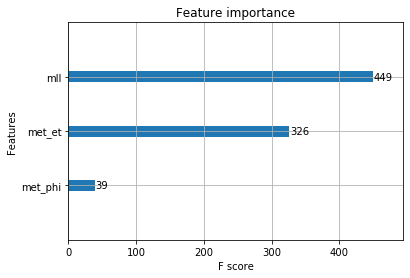

In [5]:
# BDT classifier
xgbclassifier = xgb.XGBClassifier(
    max_depth=3, 
    n_estimators=120,
    learning_rate=0.1,
    n_jobs=4,
    #scale_pos_weight=sum_wbkg/sum_wsig,
    objective='binary:logistic')
    #missing=-999.0) 
xgbclassifier.fit(X_train, Y_train) 
# Plot variable importance
fig_size = plt.rcParams["figure.figsize"] 
xgb.plot_importance(xgbclassifier)
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.show()
y_pred = xgbclassifier.predict(X_test)
y_pred_prob = xgbclassifier.predict_proba(X_test)

In [ ]:
# LOGREG classifier
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)

In [ ]:
y_pred

The following cell allow you to check the classification performance of your algorithm. The y-axis is the number of events and the x-axis is the probability that the sample is signal. The blue distribution corresponds to background and the pink to signal.

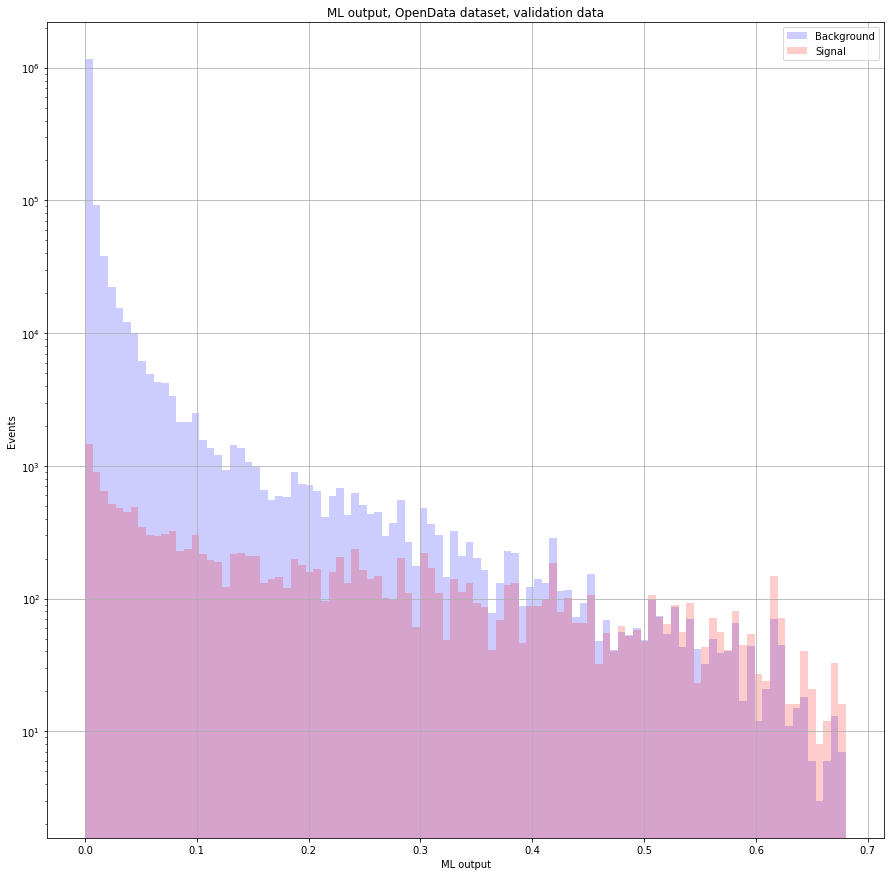

In [6]:
#  histogram of the ML outputs
n, bins, patches = plt.hist(y_pred_prob[:,1][Y_test==0], 100, normed=0, facecolor='blue', alpha=0.2,label="Background")
n, bins, patches = plt.hist(y_pred_prob[:,1][Y_test==1], 100, normed=0, facecolor='red', alpha=0.2, label="Signal")
plt.xlabel('ML output')
plt.ylabel('Events')
plt.yscale('log')
plt.title('ML output, OpenData dataset, validation data')
plt.grid(True)
plt.legend()
plt.show()

In machine learning, the performance of the algorithms are studied using the ROC curve. See any documentation of your choice on ROC curves (it is well explained on wikipedia).

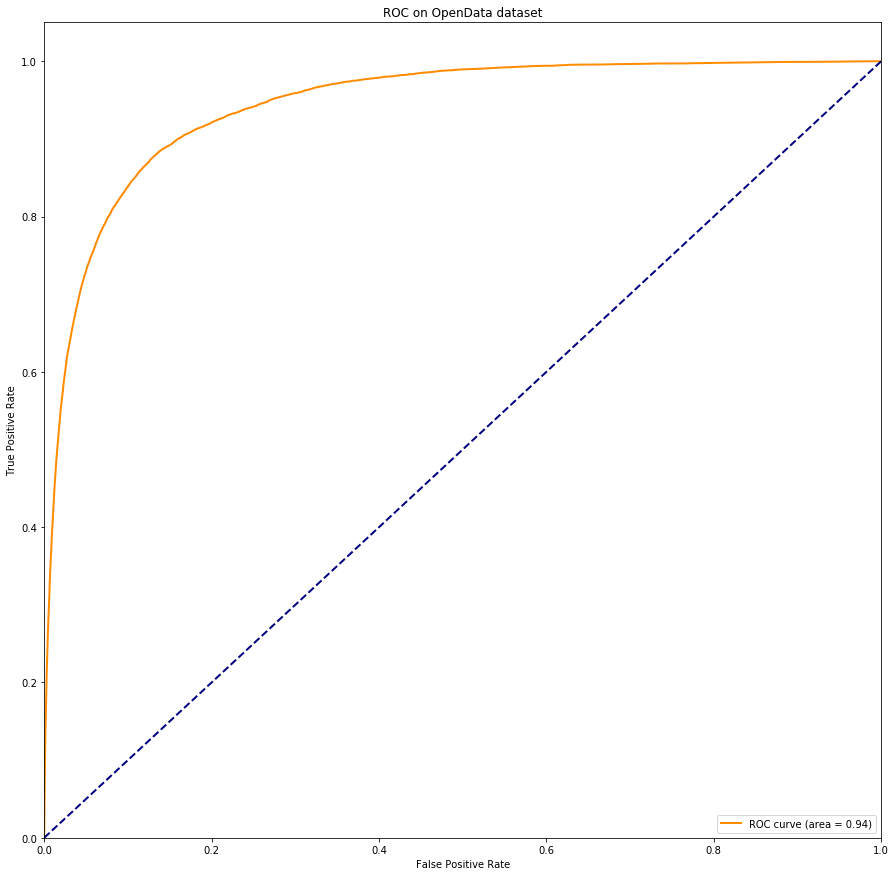

In [7]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(Y_test,y_pred_prob[:,1], pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC on OpenData dataset')
plt.legend(loc="lower right")
plt.show()

The ROC curve is related to the confusion matrix (see documentation). The confusion matrix is plotted bellow.

Confusion matrix, without normalization
[[1398719    1009]
 [  14694    1352]]


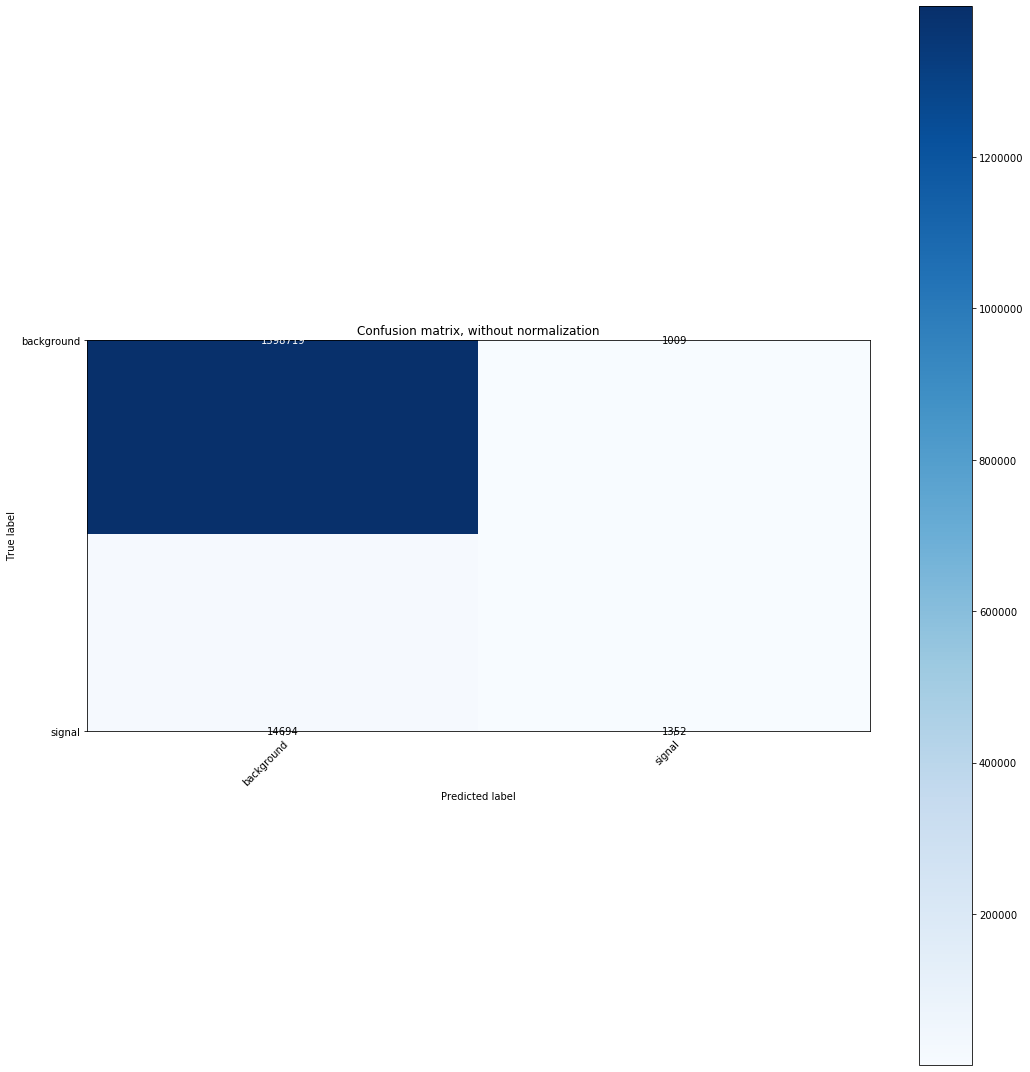

In [8]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(Y_test, y_pred, ['background','signal'], normalize=False)

It is common to compare the predicted vs. true distributions of both background and signal. 

In [9]:
m = 0
h_true_bkg = []
h_true_sig = []
for q in Y_test:
    if q == 0:
        h_true_bkg.append((X_test['mll'].iloc[m]))
    else:    
        h_true_sig.append((X_test['mll'].iloc[m]))
    m += 1

In [10]:
n = 0
h_pred_bkg = []
h_pred_sig = []
for p in y_pred:
    if p == 0:
        h_pred_bkg.append((X_test['mll'].iloc[m]))
    else:    
        h_pred_sig.append((X_test['mll'].iloc[m]))
    n += 1

IndexError: single positional indexer is out-of-bounds

In [ ]:
plt.hist(h_true_sig,bins=100,log=True)
plt.hist(h_pred_sig,bins=100,log=True)
plt.show

In [ ]:
plt.hist(h_true_bkg,bins=100,log=True)
plt.hist(h_pred_bkg,bins=100,log=True)
plt.show